/opt/anaconda3/envs/upkie/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment Upkie-Mock-Pendulum already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/upkie/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment Upkie-Mock-Servos already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/upkie/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment Upkie-Spine-Pendulum already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/anaconda3/envs/upkie/lib/python3.10/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment Upkie-Spine-Servos already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/o

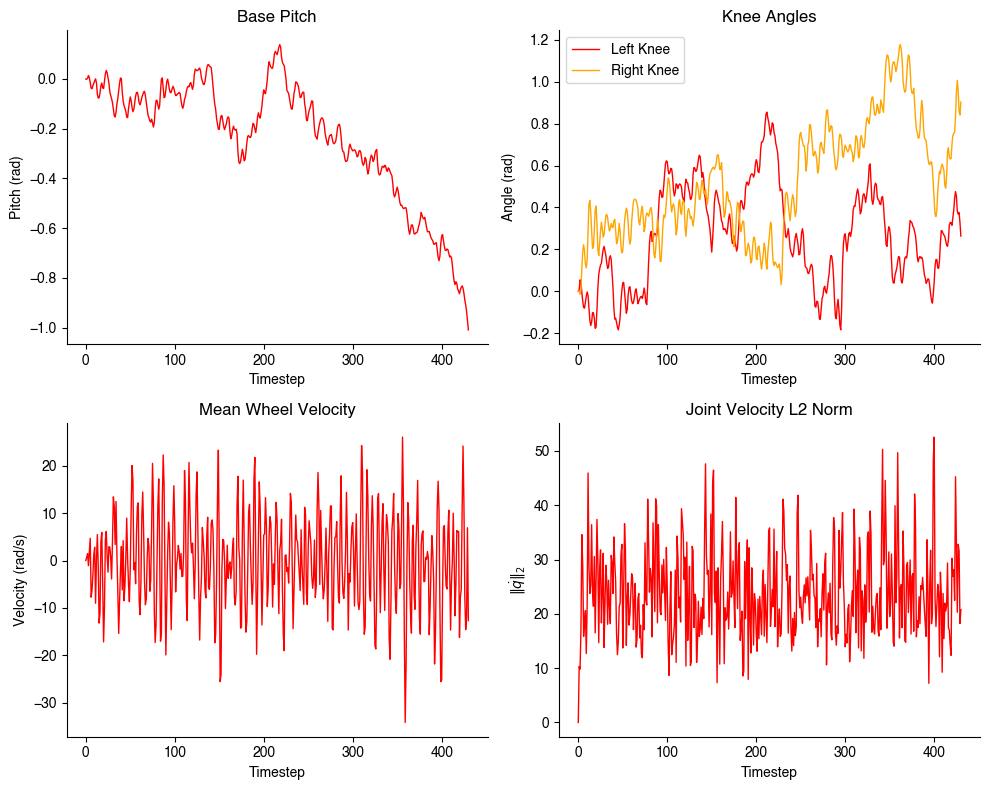

Saved Task 3 curves to: figure/Task3_training_curves.pdf


In [69]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Task 3 plotting script that matches Task 2 layout:
- single figure
- 2x2 subplots
- all curves red, equal thickness, no grid
Saved as:
figure/Task3_training_curves.pdf
"""

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import gymnasium as gym
import upkie.envs

# Use wrapped env exactly as in training & rollout
from rollout_policy_servos import make_wrapped_env

MODEL_PATH = "models/servos_best/best_model.zip"
LINEWIDTH = 1
COLOR = "red"
MAX_STEPS = 1200



upkie.envs.register()

fig_dir = Path("figure")
fig_dir.mkdir(exist_ok=True)

env = make_wrapped_env(
    frequency_hz=200.0,
    max_steps=MAX_STEPS,
    fixed_order=None,
    gains=dict(kp_wheel=0.0, kd_wheel=1.7, kp_leg=2.0, kd_leg=1.7),
)

model = PPO.load(MODEL_PATH)

obs, info = env.reset()
done = False

T = []
pitch_list = []
left_knee = []
right_knee = []
wheel_vel = []
joint_vel_norm = []

t = 0
while not done and t < MAX_STEPS:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    spine_obs = info["spine_observation"]
    servo = spine_obs["servo"]

    pitch = float(spine_obs["base_orientation"]["pitch"])
    lk = float(servo["left_knee"]["position"])
    rk = float(servo["right_knee"]["position"])
    wl = float(servo["left_wheel"]["velocity"])
    wr = float(servo["right_wheel"]["velocity"])

    vel_norm = float(np.linalg.norm([float(servo[j]["velocity"]) for j in servo]))

    T.append(t)
    pitch_list.append(pitch)
    left_knee.append(lk)
    right_knee.append(rk)
    wheel_vel.append(0.5 * (wl + wr))
    joint_vel_norm.append(vel_norm)

    t += 1
    done = bool(terminated or truncated)

# ------------------------------------------------------------
# Create 2x2 subplot layout, identical to Task 2
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

# 1) Pitch
ax1.plot(T, pitch_list, COLOR, linewidth=LINEWIDTH)
ax1.set_title("Base Pitch")
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Pitch (rad)")

# 2) Knees
ax2.plot(T, left_knee, COLOR, linewidth=LINEWIDTH, label="Left Knee")
ax2.plot(T, right_knee, "orange", linewidth=LINEWIDTH, label="Right Knee")
ax2.set_title("Knee Angles")
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Angle (rad)")
ax2.legend()

# 3) Wheel velocity
ax3.plot(T, wheel_vel, COLOR, linewidth=LINEWIDTH)
ax3.set_title("Mean Wheel Velocity")
ax3.set_xlabel("Timestep")
ax3.set_ylabel("Velocity (rad/s)")

# 4) Joint smoothness
ax4.plot(T, joint_vel_norm, COLOR, linewidth=LINEWIDTH)
ax4.set_title("Joint Velocity L2 Norm")
ax4.set_xlabel("Timestep")
ax4.set_ylabel(r"$\|\dot{q}\|_2$")

plt.tight_layout()
out_path = fig_dir / "Task3_training_curves.pdf"
plt.savefig(out_path)
plt.show()

print(f"Saved Task 3 curves to: {out_path}")


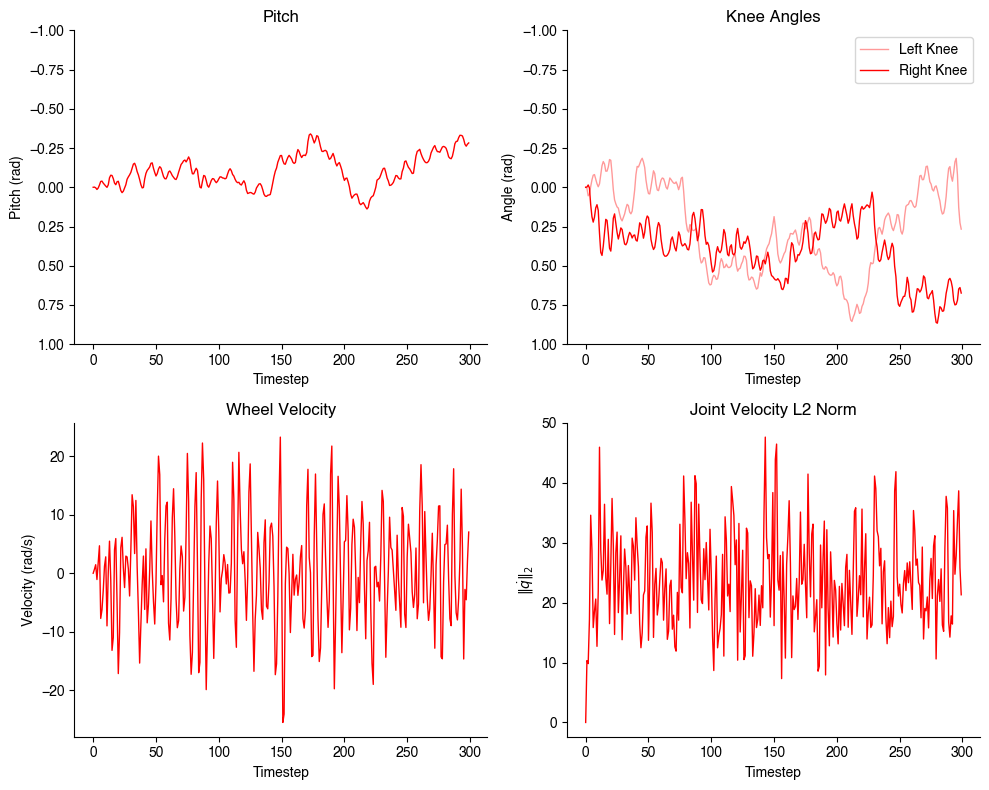

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# --- Select first 300 samples ---
N = 300
idx = np.arange(min(N, len(T)))

T_300 = np.array(T)[idx]
pitch_300 = np.array(pitch_list)[idx]
left_knee_300 = np.array(left_knee)[idx]
right_knee_300 = np.array(right_knee)[idx]
wheel_vel_300 = np.array(wheel_vel)[idx]
joint_norm_300 = np.array(joint_vel_norm)[idx]

# --- Plot: matching Task 2 style (2x2 grid) ---
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

LINEWIDTH = 1
COLOR = "red"

# 1) Pitch
ax1.plot(T_300, pitch_300, COLOR, linewidth=LINEWIDTH)
ax1.set_title("Pitch")
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Pitch (rad)")
ax1.set_ylim([1, -1])

# 2) Knees
ax2.plot(T_300, left_knee_300, "red", linewidth=LINEWIDTH, alpha=0.4, label="Left Knee")
ax2.plot(T_300, right_knee_300, "red", linewidth=LINEWIDTH, label="Right Knee")
ax2.set_title("Knee Angles")
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Angle (rad)")
ax2.set_ylim([1, -1])
ax2.legend()

# 3) Wheel velocity
ax3.plot(T_300, wheel_vel_300, COLOR, linewidth=LINEWIDTH)
ax3.set_title("Wheel Velocity")
ax3.set_xlabel("Timestep")
ax3.set_ylabel("Velocity (rad/s)")

# 4) Joint velocity norm
ax4.plot(T_300, joint_norm_300, COLOR, linewidth=LINEWIDTH)
ax4.set_title("Joint Velocity L2 Norm")
ax4.set_xlabel("Timestep")
ax4.set_ylabel(r"$\|\dot{q}\|_2$")

plt.tight_layout()
plt.savefig(fig_dir / "Task3_training_curves_zoomed.pdf")
plt.show()

[INFO] Using TensorBoard run: logs/servos_task3/PPO_9


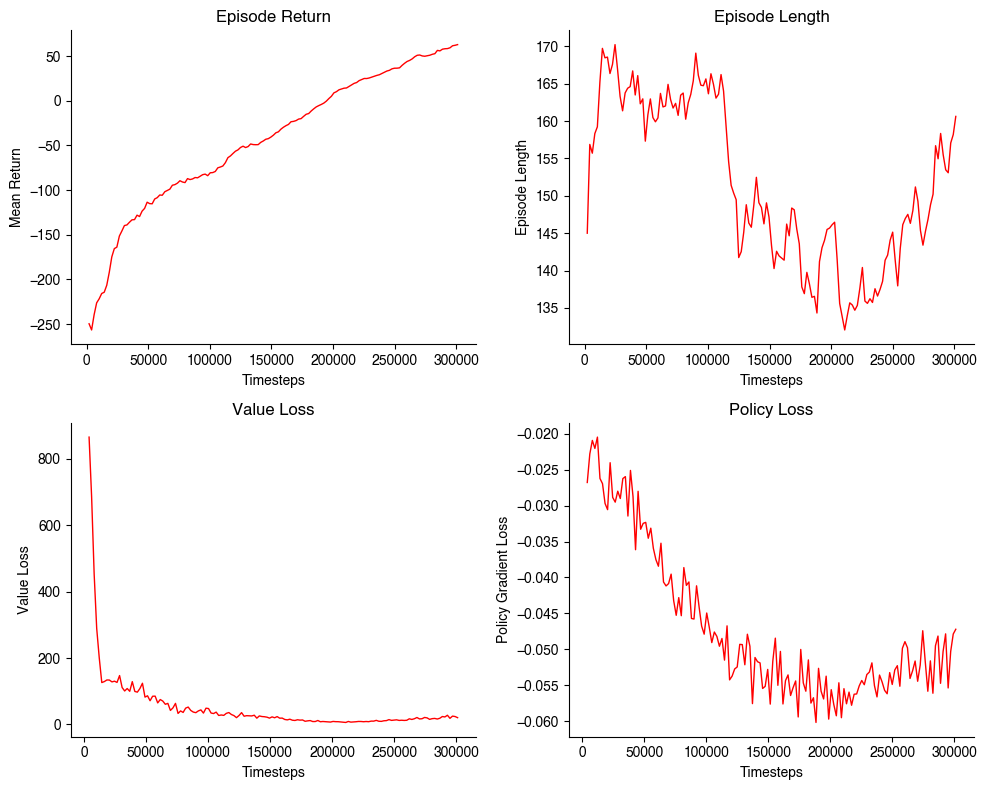

[INFO] Saved training curves to logs/servos_task3/PPO_9/Task3_training_curves.pdf


In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Plot PPO training curves for Task 3 (Upkie-Servos).
Extracts TensorBoard scalars and saves a 2x2 PDF figure:
    - Episode return
    - Episode length
    - Value loss
    - Policy gradient loss
"""

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

LOG_ROOT = Path("logs/servos_task3")

EP_REW_TAG = "rollout/ep_rew_mean"
EP_LEN_TAG = "rollout/ep_len_mean"
VALUE_LOSS_TAG = "train/value_loss"
POLICY_LOSS_TAG = "train/policy_gradient_loss"

COLOR = "red"
LW = 1

def get_latest_run_dir(log_root: Path) -> Path:
    run_dirs = [p for p in log_root.glob("*") if p.is_dir()]
    if not run_dirs:
        raise FileNotFoundError(f"No TensorBoard logs found in {log_root}")
    run_dirs.sort(key=lambda p: p.stat().st_mtime)
    return run_dirs[-1]

def load_scalars(run_dir: Path, tag: str):
    event_files = list(run_dir.glob("events.out.tfevents.*"))
    if not event_files:
        return np.array([]), np.array([])

    ea = event_accumulator.EventAccumulator(str(event_files[0]))
    ea.Reload()

    if tag not in ea.Tags().get("scalars", []):
        return np.array([]), np.array([])

    scalars = ea.Scalars(tag)
    steps = np.array([s.step for s in scalars])
    values = np.array([s.value for s in scalars])
    return steps, values

def main():
    run_dir = get_latest_run_dir(LOG_ROOT)
    print(f"[INFO] Using TensorBoard run: {run_dir}")

    steps_rew, ep_rew = load_scalars(run_dir, EP_REW_TAG)
    steps_len, ep_len = load_scalars(run_dir, EP_LEN_TAG)
    steps_vloss, vloss = load_scalars(run_dir, VALUE_LOSS_TAG)
    steps_ploss, ploss = load_scalars(run_dir, POLICY_LOSS_TAG)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()

    if ep_rew.size > 0:
        ax1.plot(steps_rew, ep_rew, COLOR, linewidth=LW)
        ax1.set_title("Episode Return")
        ax1.set_xlabel("Timesteps")
        ax1.set_ylabel("Mean Return")

    if ep_len.size > 0:
        ax2.plot(steps_len, ep_len, COLOR, linewidth=LW)
        ax2.set_title("Episode Length")
        ax2.set_xlabel("Timesteps")
        ax2.set_ylabel("Episode Length")

    if vloss.size > 0:
        ax3.plot(steps_vloss, vloss, COLOR, linewidth=LW)
        ax3.set_title("Value Loss")
        ax3.set_xlabel("Timesteps")
        ax3.set_ylabel("Value Loss")

    if ploss.size > 0:
        ax4.plot(steps_ploss, ploss, COLOR, linewidth=LW)
        ax4.set_title("Policy Loss")
        ax4.set_xlabel("Timesteps")
        ax4.set_ylabel("Policy Gradient Loss")

    plt.tight_layout()
    out_path = run_dir / "Task3_training_curves.pdf"
    plt.savefig(out_path)
    plt.show()
    print(f"[INFO] Saved training curves to {out_path}")

if __name__ == "__main__":
    main()

In [83]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Generate Task 3 training plots for ALL PPO runs in logs/servos_task3/.
Produces Task3_training_curves_<runname>.pdf for each run.
"""

from pathlib import Path
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import os

LOG_ROOT = Path("logs/servos_task3")
FIG_DIR = Path("figure")
FIG_DIR.mkdir(exist_ok=True)

# SB3 TensorBoard tags
TAGS = {
    "ep_rew": "rollout/ep_rew_mean",
    "ep_len": "rollout/ep_len_mean",
    "value_loss": "train/value_loss",
    "policy_loss": "train/policy_gradient_loss",
}

LINEWIDTH = 1.8
COLOR = "red"

def load_scalars(event_path, tag):
    """Load a scalar time series for a given TensorBoard tag."""
    ea = event_accumulator.EventAccumulator(str(event_path))
    ea.Reload()

    if tag not in ea.Tags().get("scalars", []):
        return np.array([]), np.array([])

    scalars = ea.Scalars(tag)
    steps = np.array([s.step for s in scalars], dtype=float)
    vals = np.array([s.value for s in scalars], dtype=float)
    return steps, vals


def plot_run(run_dir: Path):
    """Generate 4-panel PPO training curve figure for a given run."""
    event_files = list(run_dir.glob("events.out.tfevents.*"))
    if not event_files:
        print(f"[WARN] No event files in {run_dir}")
        return

    event_path = event_files[0]
    run_name = run_dir.name

    print(f"[INFO] Processing run: {run_name}")

    # Load all curves
    curves = {k: load_scalars(event_path, tag) for k, tag in TAGS.items()}

    # Make 2×2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()

    # Episode return
    steps, vals = curves["ep_rew"]
    if vals.size > 0:
        ax1.plot(steps, vals, COLOR, linewidth=LINEWIDTH)
    ax1.set_title("Episode Return vs Timesteps")
    ax1.set_xlabel("Timesteps")
    ax1.set_ylabel("Mean Episode Return")

    # Episode length
    steps, vals = curves["ep_len"]
    if vals.size > 0:
        ax2.plot(steps, vals, COLOR, linewidth=LINEWIDTH)
    ax2.set_title("Episode Length vs Timesteps")
    ax2.set_xlabel("Timesteps")
    ax2.set_ylabel("Mean Episode Length")

    # Value loss
    steps, vals = curves["value_loss"]
    if vals.size > 0:
        ax3.plot(steps, vals, COLOR, linewidth=LINEWIDTH)
    ax3.set_title("Value Loss vs Timesteps")
    ax3.set_xlabel("Timesteps")
    ax3.set_ylabel("Value Loss")

    # Policy gradient loss
    steps, vals = curves["policy_loss"]
    if vals.size > 0:
        ax4.plot(steps, vals, COLOR, linewidth=LINEWIDTH)
    ax4.set_title("Policy Loss vs Timesteps")
    ax4.set_xlabel("Timesteps")
    ax4.set_ylabel("Policy Gradient Loss")

    # Remove grids for uniform look
    for ax in axes.flatten():
        ax.grid(False)

    plt.tight_layout()

    out_path = FIG_DIR / f"Task3_training_curves_{run_name}.pdf"
    plt.savefig(out_path)
    plt.close()

    print(f"[OK] Saved: {out_path}")


def main():
    runs = [p for p in LOG_ROOT.glob("*") if p.is_dir()]
    if not runs:
        print("[ERROR] No runs found in logs/servos_task3/")
        return

    for run in runs:
        plot_run(run)


if __name__ == "__main__":
    main()

[INFO] Processing run: PPO_9
[OK] Saved: figure/Task3_training_curves_PPO_9.pdf
[INFO] Processing run: PPO_7
[OK] Saved: figure/Task3_training_curves_PPO_7.pdf
[INFO] Processing run: PPO_1
[OK] Saved: figure/Task3_training_curves_PPO_1.pdf
[INFO] Processing run: PPO_6
[OK] Saved: figure/Task3_training_curves_PPO_6.pdf
[INFO] Processing run: PPO_8
[OK] Saved: figure/Task3_training_curves_PPO_8.pdf
[INFO] Processing run: PPO_3
[OK] Saved: figure/Task3_training_curves_PPO_3.pdf
[INFO] Processing run: PPO_4
[OK] Saved: figure/Task3_training_curves_PPO_4.pdf
[INFO] Processing run: PPO_5
[OK] Saved: figure/Task3_training_curves_PPO_5.pdf
[INFO] Processing run: PPO_2
[OK] Saved: figure/Task3_training_curves_PPO_2.pdf


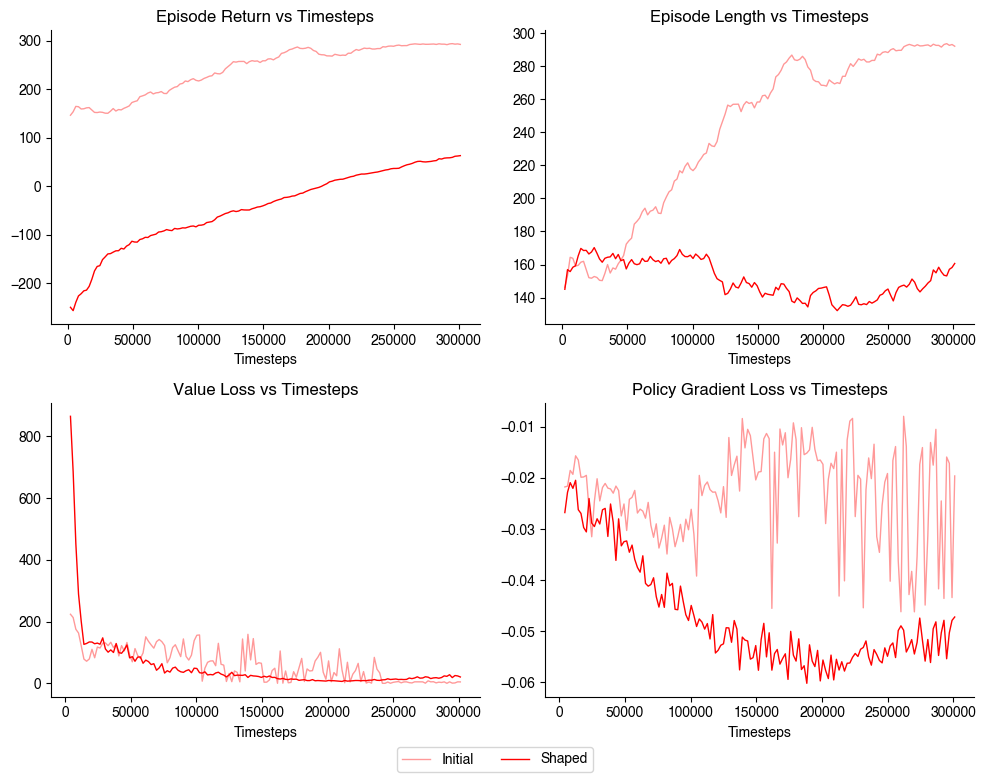

[OK] Saved overlay plot to figure/Task3_training_overlay_Initial_vs_Shaped.pdf


In [100]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Overlay Task 3 training curves: Initial (PPO_3) vs Shaped (PPO_9),
with a single legend centered at the bottom.
"""

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

LOG_ROOT = Path("logs/servos_task3")
FIG_DIR = Path("figure")
FIG_DIR.mkdir(exist_ok=True)

RUNS = {
    "PPO_3": ("Initial", 0.4),   # label, alpha
    "PPO_9": ("Shaped", 1.0)
}

TAGS = {
    "ep_rew": "rollout/ep_rew_mean",
    "ep_len": "rollout/ep_len_mean",
    "value_loss": "train/value_loss",
    "policy_loss": "train/policy_gradient_loss",
}

COLOR = "red"
LINEWIDTH = 1.0


def load_scalars(event_path, tag):
    ea = event_accumulator.EventAccumulator(str(event_path))
    ea.Reload()

    if tag not in ea.Tags().get("scalars", []):
        return np.array([]), np.array([])

    data = ea.Scalars(tag)
    steps = np.array([d.step for d in data])
    vals = np.array([d.value for d in data])
    return steps, vals


def plot_overlay():
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()

    legend_handles = []
    legend_labels = []

    for run_name, (label, alpha) in RUNS.items():
        run_dir = LOG_ROOT / run_name
        event_files = list(run_dir.glob("events.out.tfevents.*"))
        if not event_files:
            print(f"[WARN] No event files for {run_name}")
            continue

        steps_rew, ep_rew = load_scalars(event_files[0], TAGS["ep_rew"])
        steps_len, ep_len = load_scalars(event_files[0], TAGS["ep_len"])
        steps_vloss, vloss = load_scalars(event_files[0], TAGS["value_loss"])
        steps_ploss, ploss = load_scalars(event_files[0], TAGS["policy_loss"])

        # We store handles only once (for legend)
        handle = None

        if ep_rew.size > 0:
            handle, = ax1.plot(
                steps_rew, ep_rew,
                COLOR, linewidth=LINEWIDTH, alpha=alpha
            )
        if ep_len.size > 0:
            ax2.plot(steps_len, ep_len, COLOR, linewidth=LINEWIDTH, alpha=alpha)
        if vloss.size > 0:
            ax3.plot(steps_vloss, vloss, COLOR, linewidth=LINEWIDTH, alpha=alpha)
        if ploss.size > 0:
            ax4.plot(steps_ploss, ploss, COLOR, linewidth=LINEWIDTH, alpha=alpha)

        if handle:
            legend_handles.append(handle)
            legend_labels.append(label)

    # Titles
    ax1.set_title("Episode Return vs Timesteps")
    ax2.set_title("Episode Length vs Timesteps")
    ax3.set_title("Value Loss vs Timesteps")
    ax4.set_title("Policy Gradient Loss vs Timesteps")

    for ax in axes.flatten():
        ax.set_xlabel("Timesteps")
        ax.grid(False)

    # --- SINGLE LEGEND AT BOTTOM ---
    fig.legend(
        legend_handles,
        legend_labels,
        loc="lower center",
        ncol=2,
        frameon=True,
        fontsize=10,
        bbox_to_anchor=(0.5, 0.02)
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    out_path = FIG_DIR / "Task3_training_overlay_Initial_vs_Shaped.pdf"
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()

    print(f"[OK] Saved overlay plot to {out_path}")


plot_overlay()